In [2]:
pip install minisom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=6644fc539cba5753b6c4f121ffadb995c413aa22ba88f6d022bd977a985a3260
  Stored in directory: /root/.cache/pip/wheels/19/db/95/5e53bc2b88a328217fdf9f2886cafbe86b0df274f4b601f572
Successfully built minisom


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from minisom import MiniSom  # pip install minisom


In [4]:
iris = datasets.load_iris()
X = iris.data
y = iris.target


In [5]:
from scipy.stats import zscore
z_scores = np.abs(zscore(X))
outliers = (z_scores > 3).any(axis=1)
print(f"Total de outliers encontrados: {outliers.sum()}")


Total de outliers encontrados: 1


In [6]:
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)


In [7]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(X_normalized)


In [8]:
sil_score = silhouette_score(X_normalized, y_kmeans)
print(f"Silhouette Score (KMeans): {sil_score:.2f}")


Silhouette Score (KMeans): 0.48


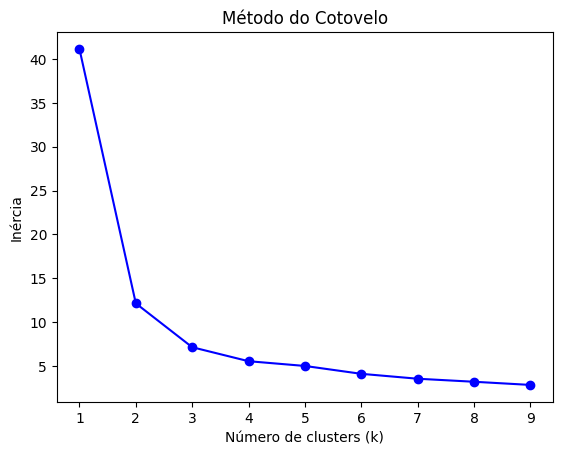

In [9]:
inertia = []
k_values = range(1, 10)
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_normalized)
    inertia.append(km.inertia_)

plt.plot(k_values, inertia, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo')
plt.show()


In [10]:
def dunn_index(X, labels):
    unique_clusters = np.unique(labels)
    intra_dists = []
    inter_dists = []
    for i in unique_clusters:
        cluster_i = X[labels == i]
        if len(cluster_i) > 1:
            intra = np.max([np.linalg.norm(a-b) for a in cluster_i for b in cluster_i])
            intra_dists.append(intra)
    for i in unique_clusters:
        for j in unique_clusters:
            if i != j:
                cluster_i = X[labels == i]
                cluster_j = X[labels == j]
                inter = np.min([np.linalg.norm(a-b) for a in cluster_i for b in cluster_j])
                inter_dists.append(inter)
    return np.min(inter_dists) / np.max(intra_dists)

dunn = dunn_index(X_normalized, y_kmeans)
print(f"Dunn Index (KMeans): {dunn:.2f}")


Dunn Index (KMeans): 0.05


In [11]:
dbscan = DBSCAN(eps=0.2, min_samples=5)
y_dbscan = dbscan.fit_predict(X_normalized)


In [12]:
som = MiniSom(5, 5, X_normalized.shape[1], sigma=0.5, learning_rate=0.5, random_seed=42)
som.train(X_normalized, 100)
y_som = np.array([np.ravel_multi_index(som.winner(x), (5,5)) for x in X_normalized])


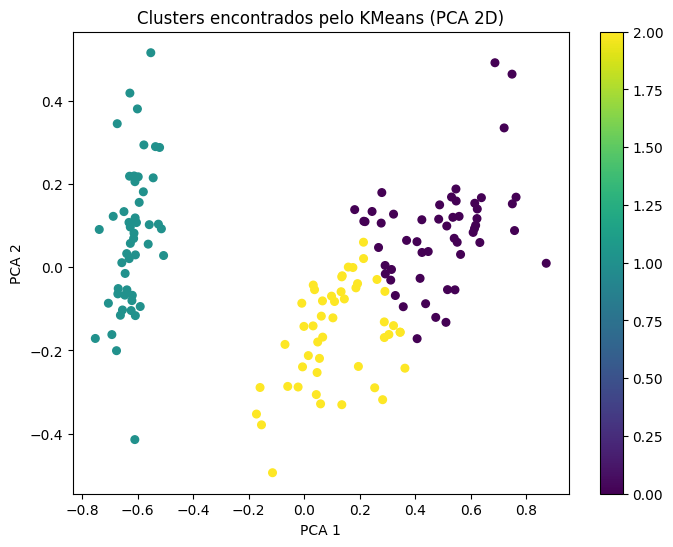

In [13]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_kmeans, cmap='viridis', s=30)
plt.title('Clusters encontrados pelo KMeans (PCA 2D)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar()
plt.show()


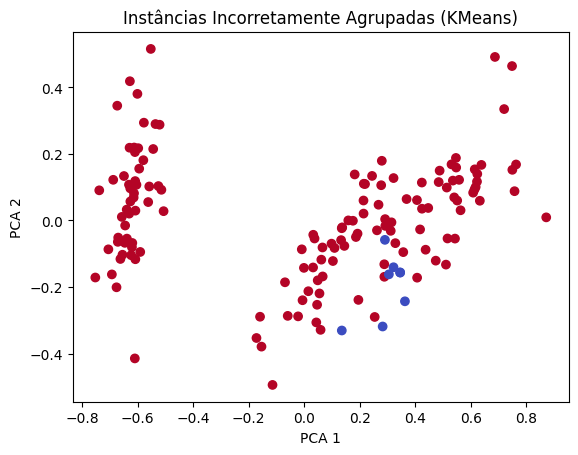

In [14]:
wrong = y_kmeans != y
plt.scatter(X_pca[:,0], X_pca[:,1], c=wrong, cmap='coolwarm')
plt.title('Instâncias Incorretamente Agrupadas (KMeans)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()
